# Training the triple tank example

In this file, a pytorch based neural network is trained

In [15]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import sys
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch

In [16]:
rel_do_mpc_path = os.path.join('..','..')
sys.path.append(rel_do_mpc_path)
import do_mpc

## defining the system

In [17]:
def template_model():
    # init
    model = do_mpc.model.Model('continuous', symvar_type='SX')

    # Define the states
    position = model.set_variable(var_type='_x', var_name='position', shape=(1,1))
    velocity = model.set_variable(var_type='_x', var_name='velocity', shape=(1,1))

    # Define the control inputs
    f_external = model.set_variable(var_type='_u', var_name='f_external', shape=(1,1))

    # constants
    k = 10      # spring constant
    c = 2       # damping constant
    mass = 0.1  # mass of the object

    # Define the model equations
    model.set_rhs('position', velocity)
    model.set_rhs('velocity', (-k*position - c*velocity + f_external)/mass)

    # model setup
    model.setup()

    # end
    return model

In [18]:
model = template_model()

In [19]:
def template_simulator(model):
    # init
    simulator = do_mpc.simulator.Simulator(model)
    
    # set t_step
    simulator.set_param(t_step = 0.1)

    # tvp
    tvp_template = simulator.get_tvp_template()

    def tvp_fun(t_ind):
        return tvp_template

    simulator.set_tvp_fun(tvp_fun)
    
    # simulator setup
    simulator.setup()

    # end
    return simulator

In [20]:
simulator = template_simulator(model=model)

## sampling data

In [21]:
def random_input_sampler(model, simulator, lbx, ubx, lbu, ubu, n_samples, change_probability = 0.7):

    # setting up sysetm
    estimator = do_mpc.estimator.StateFeedback(model= model)

    # random initial state
    x0_init = np.random.uniform(lbx, ubx).reshape((model.n_x, 1))

    simulator.x0 = x0_init
    simulator.set_initial_guess()

    for i in tqdm(range(n_samples), desc= 'Generating data'):

        # executes if the system decides for a change
        if i==0 or np.random.rand() < change_probability:
            #u0 = np.random.uniform(system.lbu, system.ubu).reshape((-1,1))
            u0 = np.random.uniform(lbu, ubu).reshape((-1,1))
            u_prev = u0

        # executes if the system decides to not change
        else:
            u0 = u_prev

        y_next = simulator.make_step(u0)
        x0 = estimator.make_step(y_next)

    # states
    x_names = [f'state_{i + 1}' for i in range(simulator.data['_x'].shape[1])]
    df_x = pd.DataFrame(simulator.data['_x'], columns=x_names)

    # inputs
    u_names = [f'input_{i + 1}' for i in range(simulator.data['_u'].shape[1])]
    df_u = pd.DataFrame(simulator.data['_u'], columns=u_names)

    # time
    t_names = ['time']
    df_t = pd.DataFrame(simulator.data['_time'], columns=t_names)

    # final df
    df = pd.concat([df_t, df_x, df_u], axis=1)

    return df

In [22]:
simulation_data = random_input_sampler(model=model, simulator=simulator, lbx = np.array([-0.01, -2.65/100]), ubx = np.array([0.01, 2.65/100]), lbu = np.array([-0.1]), ubu = np.array([0.1]), n_samples = 10000)
simulation_data

Generating data: 100%|██████████| 10000/10000 [00:02<00:00, 4123.26it/s]


,time,state_1,state_2,input_1
0,0.0,0.002716,-0.024041,0.059048
1,0.1,0.002674,0.011732,0.059048
2,0.2,0.003959,0.011885,0.089354
3,0.3,0.005711,0.018306,0.089354
4,0.4,0.007237,0.011860,0.089354
...,...,...,...,...
9995,999.5,-0.004673,0.020069,-0.079128
9996,999.6,-0.004791,-0.011919,0.076847
9997,999.7,-0.001933,0.045894,-0.033337
9998,999.8,-0.000614,-0.005154,-0.033337


## preprocessing data
This step shifts the data according to the requirements of the order of the narxing.

In [23]:
def simulation_2_narx(df, n_x, n_u, order):

    # init
    df_new = df.copy()
    x_names = [f'state_{i + 1}' for i in range(n_x)]
    u_names = [f'input_{i + 1}' for i in range(n_u)]

    # Add lagged columns
    for i in range(-1, order):
        for col in x_names:
            col_name = f"{col}_lag_{i+1}"
            df_new[col_name] = df_new[col].shift(i)

    # Add lagged columns
    for i in range(order):
        for col in u_names:
            col_name = f"{col}_lag_{i}"
            df_new[col_name] = df_new[col].shift(i)

    # clean up
    df_new.drop(columns=x_names+u_names, inplace= True)
    df_new.dropna(inplace=True)
    df_new.reset_index(inplace=True, drop=True)

    # labels for dataset
    y_label = [f'state_{i + 1}_lag_0' for i in range(n_x)]
    x_label=[]
    for i in range(order+1):
        for j, col in enumerate(x_names):
            if i > 0:
                col_name = f"{col}_lag_{i}"
                x_label.append(col_name)
    for i in range(order):
        for col in u_names:
            col_name = f"{col}_lag_{i}"
            x_label.append(col_name)

    # end
    return df_new, x_label, y_label

In [24]:
train_data, x_label, y_label = simulation_2_narx(df=simulation_data, n_x=model.n_x, n_u=model.n_u, order=1)
train_data

,time,state_1_lag_0,state_2_lag_0,state_1_lag_1,state_2_lag_1,input_1_lag_0
0,0.0,0.002674,0.011732,0.002716,-0.024041,0.059048
1,0.1,0.003959,0.011885,0.002674,0.011732,0.059048
2,0.2,0.005711,0.018306,0.003959,0.011885,0.089354
3,0.3,0.007237,0.011860,0.005711,0.018306,0.089354
4,0.4,0.008122,0.006249,0.007237,0.011860,0.089354
...,...,...,...,...,...,...
9994,999.4,-0.004673,0.020069,-0.005457,-0.017869,-0.000016
9995,999.5,-0.004791,-0.011919,-0.004673,0.020069,-0.079128
9996,999.6,-0.001933,0.045894,-0.004791,-0.011919,0.076847
9997,999.7,-0.000614,-0.005154,-0.001933,0.045894,-0.033337


## initialize a pytorch nn

In [25]:
class Regressor(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_layers):
        super(Regressor, self).__init__()

        # Set datatype
        torch.set_default_dtype(torch.float64)

        # Build the neural network dynamically based on the number of layers
        layers = []

        # Input layer (from input_size to the first hidden layer)
        layers.append(torch.nn.Linear(input_size, hidden_layers[0]))
        layers.append(torch.nn.Tanh())

        # Hidden layers (from one hidden layer to the next)
        for i in range(1, len(hidden_layers)):
            layers.append(torch.nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            layers.append(torch.nn.Tanh())

        # Output layer (from the last hidden layer to output_size)
        layers.append(torch.nn.Linear(hidden_layers[-1], output_size))

        # Combine all layers into a sequential model
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the network
        return self.network(x)

## train a nn approximation of the simulator

In [26]:
def train_nn(x_train, y_train, hidden_layers, epochs=1000, batch_size=1000, val_split=0.2):
    # init
    train_history = {'training_loss': [],
                         'validation_loss': [],
                         'learning_rate': [],
                         'epochs': []}
    
    # model init
    narx_model = Regressor(input_size=model.n_x + model.n_u, output_size=model.n_x, hidden_layers=hidden_layers)

    # setting up Mean Squared Error as loss function for training
    criterion = torch.nn.MSELoss()

    # setting up optimiser for training
    optimizer = torch.optim.AdamW(narx_model.parameters(), lr=0.1)

    # scheduler setup
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    # converting datasets to tensors
    X_torch = torch.tensor(x_train.to_numpy(), dtype=torch.float64)
    Y_torch = torch.tensor(y_train.to_numpy(), dtype=torch.float64)

    # Create TensorDataset
    dataset = torch.utils.data.TensorDataset(X_torch, Y_torch)

    # splitting full datset
    train_dataset, validation_dataset = (torch.utils.data.random_split(dataset= dataset, lengths=[1-val_split, val_split]))

    # creating DataLoader with batch_size
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

    # main training loop
    for epoch in tqdm(range(epochs), desc= 'Training NARX'):

        # narx training
        train_loss = 0
        for batch_X, batch_Y in train_dataloader:

            # Forward pass
            predictions = narx_model(batch_X).squeeze()
            loss = criterion(predictions, batch_Y)

            # Backward pass / parameters update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # storing loss
            train_loss += loss.item()

        # narx validation
        val_loss = 0
        for batch_X, batch_Y in validation_dataloader:
            with torch.no_grad():
                predictions = narx_model(batch_X).squeeze()
                val_loss += criterion(predictions, batch_Y).item()

        # storing data
        train_history['training_loss'].append(train_loss)
        train_history['validation_loss'].append(val_loss)
        train_history['epochs'].append(epoch)
        train_history['learning_rate'].append(optimizer.param_groups[0]["lr"])

        # learning rate update
        lr_scheduler.step(val_loss)

        # break if training min learning rate is reached
        if optimizer.param_groups[0]["lr"] <= 1e-8:
            break

    # plot training performance
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)

    # Plot 1: Loss History
    ax1.plot(train_history['epochs'], train_history['training_loss'], label='Training Loss', color='green')
    ax1.set_ylabel('Training Loss (log)')
    ax1.set_yscale('log')

    ax1b = ax1.twinx()
    ax1b.plot(train_history['epochs'], train_history['validation_loss'], label='Validation Loss', color='red')
    ax1b.set_ylabel('Validation Loss (log)', color='red')
    ax1b.set_yscale('log')

    # Legends for both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1b.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    # Plot 2: Learning Rate
    ax2.plot(train_history['epochs'], train_history['learning_rate'], color='blue')
    ax2.set_ylabel('Learning Rate (log)')
    ax2.set_xlabel('Epochs')
    ax2.set_yscale('log')

    # Overall title and layout
    fig.suptitle('NARX Training History', fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle

    plt.show()

    # end
    return narx_model

Training NARX: 100%|██████████| 50/50 [00:01<00:00, 43.27it/s]


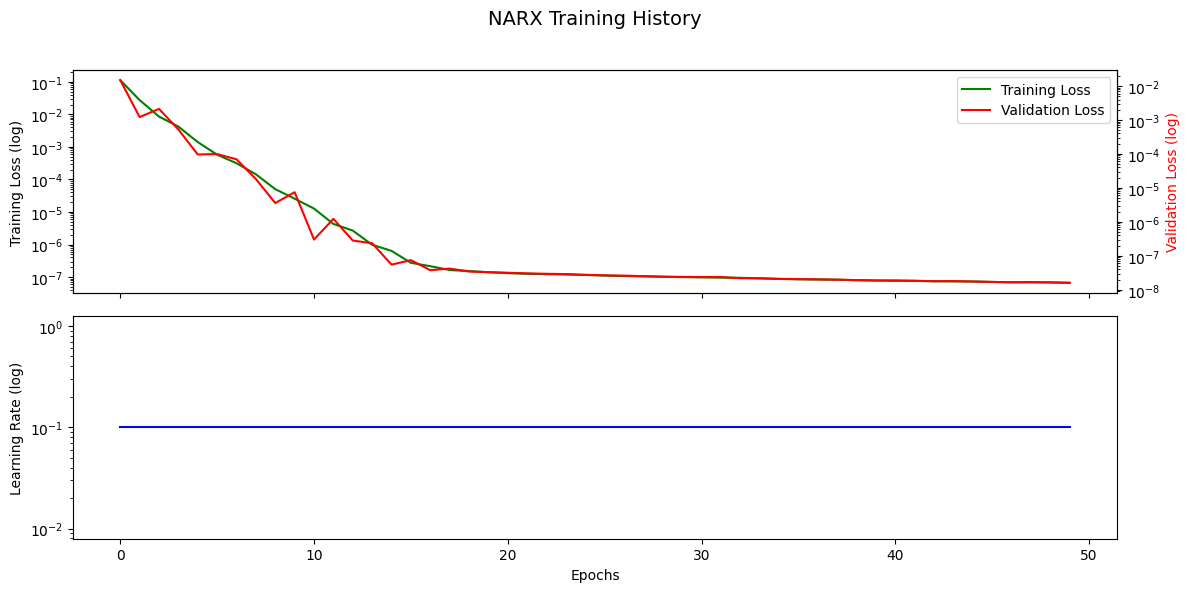

In [27]:
narx_model = train_nn(x_train=train_data[x_label], y_train=train_data[y_label], hidden_layers=[10], epochs=50, batch_size=1000, val_split=0.2)

In [28]:
state_dict=narx_model.state_dict()
# Strip the "network." prefix from keys
stripped_state_dict = {
    k.replace("network.", ""): v
    for k, v in state_dict.items()
}
torch.save(stripped_state_dict, 'model_weights.pth')